Расстояние A—B: 1280.70 м
Половина расстояния: 640.35 м
Минимакс-точка: (55.759584, 37.648832)


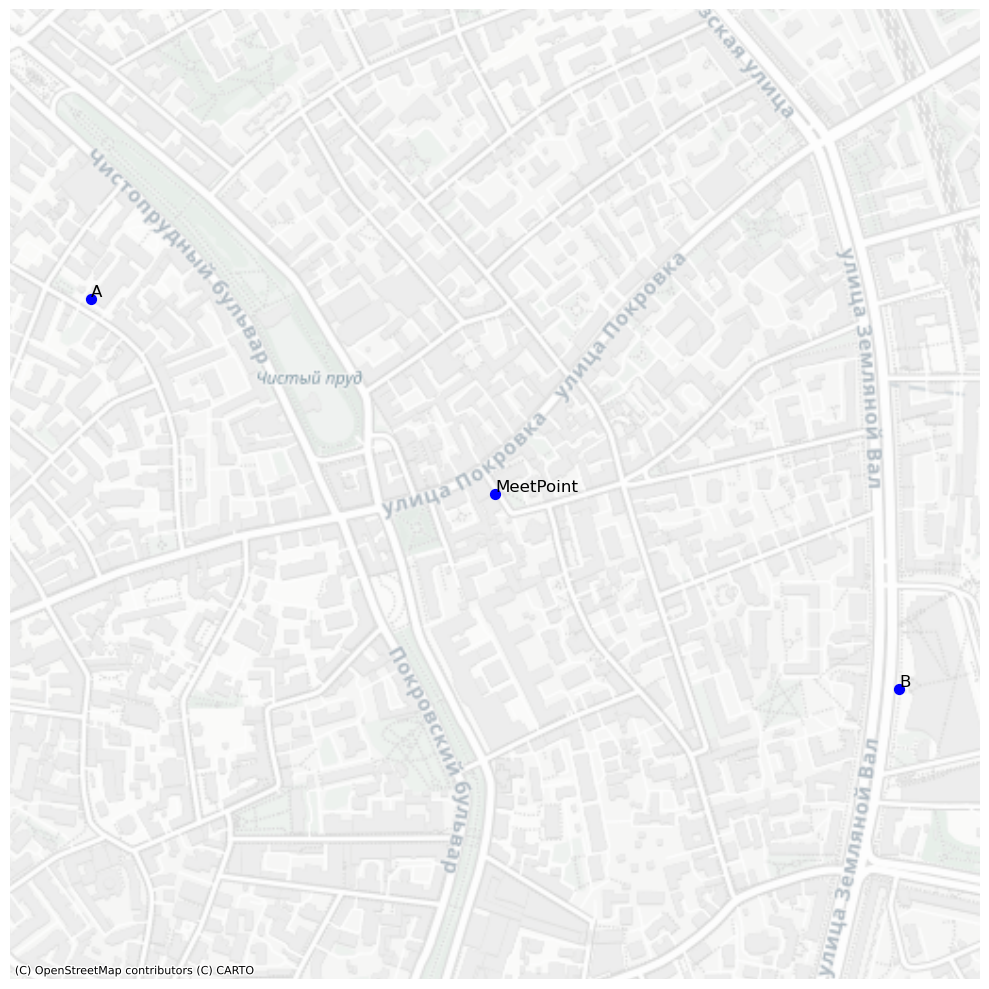

In [ ]:
import contextily as cx  # type: ignore
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Geod
from shapely.geometry import Point

"""
Поиск оптимальной точки встречи для двух людей,
которые двигаются с одинаковой скоростью по прямой линии.
"""

geod = Geod(ellps="WGS84")

point_a = Point(37.639637, 55.762074)
point_b = Point(37.658026, 55.757094)


def get_geodetic_distance(point_a: Point, point_b: Point) -> float:
    """Длина кратчайшей дуги между точками в метрах."""
    _, _, dist = geod.inv(point_a.x, point_a.y, point_b.x, point_b.y)
    return dist


def get_meetpoint(a: Point, b: Point) -> Point:
    """
    Минимакс-точка для равных скоростей и одновременного старта —
    середина геодезической дуги между A и B.
    Возвращает shapely.Point(lon, lat) в WGS84.
    """
    # npts вернет N промежуточных точек на дуге; для середины нужен ровно 1
    mid_lon, mid_lat = geod.npts(a.x, a.y, b.x, b.y, 1)[0]
    return Point(mid_lon, mid_lat)


dist = get_geodetic_distance(point_a, point_b)
meetpoint = get_meetpoint(point_a, point_b)

print(f"Расстояние A—B: {dist:.2f} м")
print(f"Половина расстояния: {dist / 2:.2f} м")
print("Минимакс-точка:", (round(meetpoint.y, 6), round(meetpoint.x, 6)))

# Визуализируем результат на карте
gdf = gpd.GeoDataFrame(
    {"role": ["A", "B", "MeetPoint"]},
    geometry=[point_a, point_b, meetpoint],
    crs="EPSG:4326",
)
gdf_web = gdf.to_crs("EPSG:3857")

fig, ax = plt.subplots(figsize=(10, 10))

# Зададим границы области отображения квадратными и с запасом
# Это необходимо для случаев когда точки расположены примерно на одной линии
xmin, ymin, xmax, ymax = gdf_web.total_bounds
xrange = float(xmax - xmin)
yrange = float(ymax - ymin)
buffer = max(xrange, yrange) * 0.2
max_range = max(xrange, yrange) + buffer
xmid = (xmin + xmax) / 2
ymid = (ymin + ymax) / 2
xmin, xmax = xmid - max_range / 2, xmid + max_range / 2
ymin, ymax = ymid - max_range / 2, ymid + max_range / 2
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

cx.add_basemap(ax, crs=gdf_web.crs, source=cx.providers.CartoDB.Positron)
gdf_web.plot(ax=ax, color="blue", markersize=50)
# Подписи для точек
for x, y, label in zip(gdf_web.geometry.x, gdf_web.geometry.y, gdf_web["role"]):
    ax.text(x, y, label, fontsize=12, va="bottom", color="black")
ax.set_axis_off()
plt.tight_layout()
plt.show()
